In [1]:
import os, h5py
import numpy as np
from tqdm.notebook import tqdm, trange

In [2]:
import torch 
from sbi import utils as Ut
from sbi import inference as Inference

In [3]:
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

seed = 12387
torch.manual_seed(seed)
if cuda: 
    torch.cuda.manual_seed(seed)

In [5]:
dat_dir = '/scratch/gpfs/chhahn/21cmlfi/'
f = h5py.File(os.path.join(dat_dir, '21cmlfi.hdf5'), 'r')

thetas = f['theta'][...]
obs = f['Del2_21_noise'][...]

f.close()

In [6]:
print('Ntrain = %i' % thetas.shape[0])

Ntrain = 124027


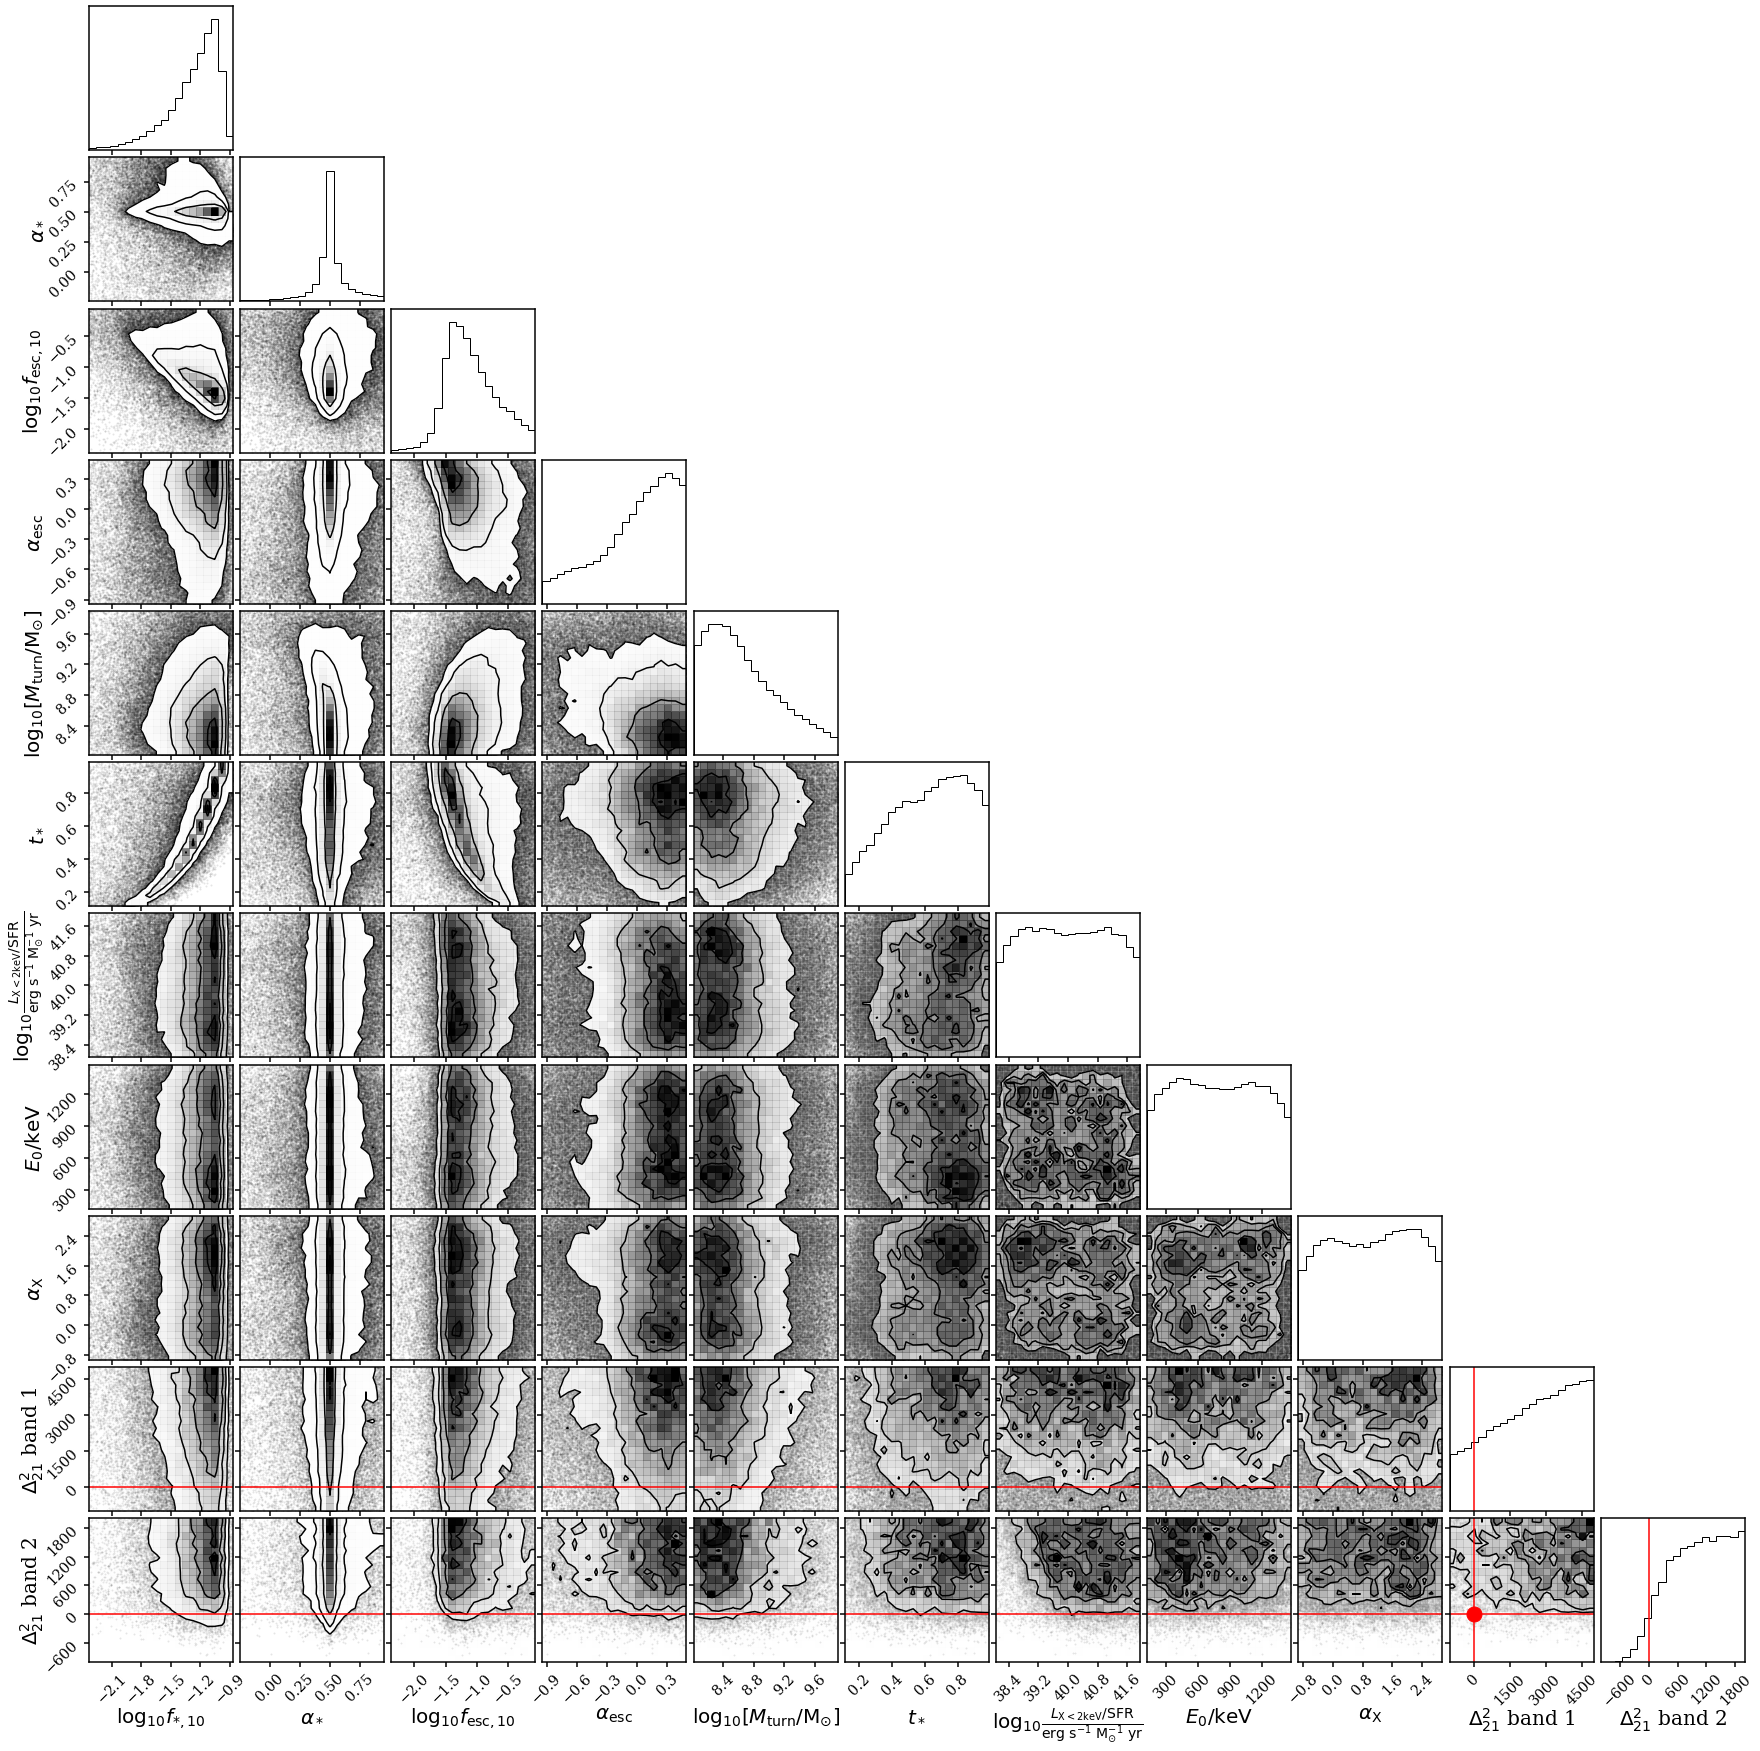

In [7]:
lbl_params = np.array([r"$\log_{10} f_{*,10}$",
                       r"$\alpha_*$",
                       r"$\log_{10} f_{\rm esc, 10}$",
                       r"$\alpha_{\rm esc}$",
                       r"$\log_{10}[M_{\rm turn}/{\rm M}_{\odot}]$",
                       r"$t_*$",
                       r"$\log_{10}\frac{L_{\rm X<2keV}/{\rm SFR}}{{\rm erg\ s^{-1}\ M_{\odot}^{-1}\ yr}}$",
                       r"$E_0/{\rm keV}$",
                       r"$\alpha_{\rm X}$"])

prior_params = [[-3,0], [-0.5,1], [-3,0],[-1,0.5], [8,10], [0.01,1], [38,42], [0.1,1.5], [-1,3]]

fig = DFM.corner(np.concatenate([thetas, obs], axis=1), 
                 range=[np.quantile(tt, (0.01, 0.99)) for tt in thetas.T] + [(-1000., 5000), (-1000., 2000)],  
                 labels=list(lbl_params) + [r'$\Delta_{21}^2$ band 1', r'$\Delta_{21}^2$ band 2'],
                 label_kwargs={'fontsize': 20})
# DFM.overplot_points(fig, [[None for _ in lbl_params] + [1700, 200]], color='r', markersize=30)
# DFM.overplot_lines(fig, [None for _ in lbl_params] + [1700, 200], color='r')
DFM.overplot_points(fig, [[None for _ in lbl_params] + [0, 0]], color='r', markersize=30)
DFM.overplot_lines(fig, [None for _ in lbl_params] + [0, 0], color='r')

# derive NPE posterior for measurement 
$${\bf x} = [1700, 200]$$

In [8]:
dir_npe = '/scratch/gpfs/chhahn/21cmlfi/npes/'
best_phat = torch.load(os.path.join(dir_npe, 'npe.erf_1x.pt'), map_location=torch.device('cpu'))

In [9]:
# sample posterior p(theta | x)
delta_obs = [1700., 200.]

mcmc_npe = best_phat.sample((10000,), x=torch.as_tensor(np.array(delta_obs).astype(np.float32)).to('cpu'), show_progress_bars=True)

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

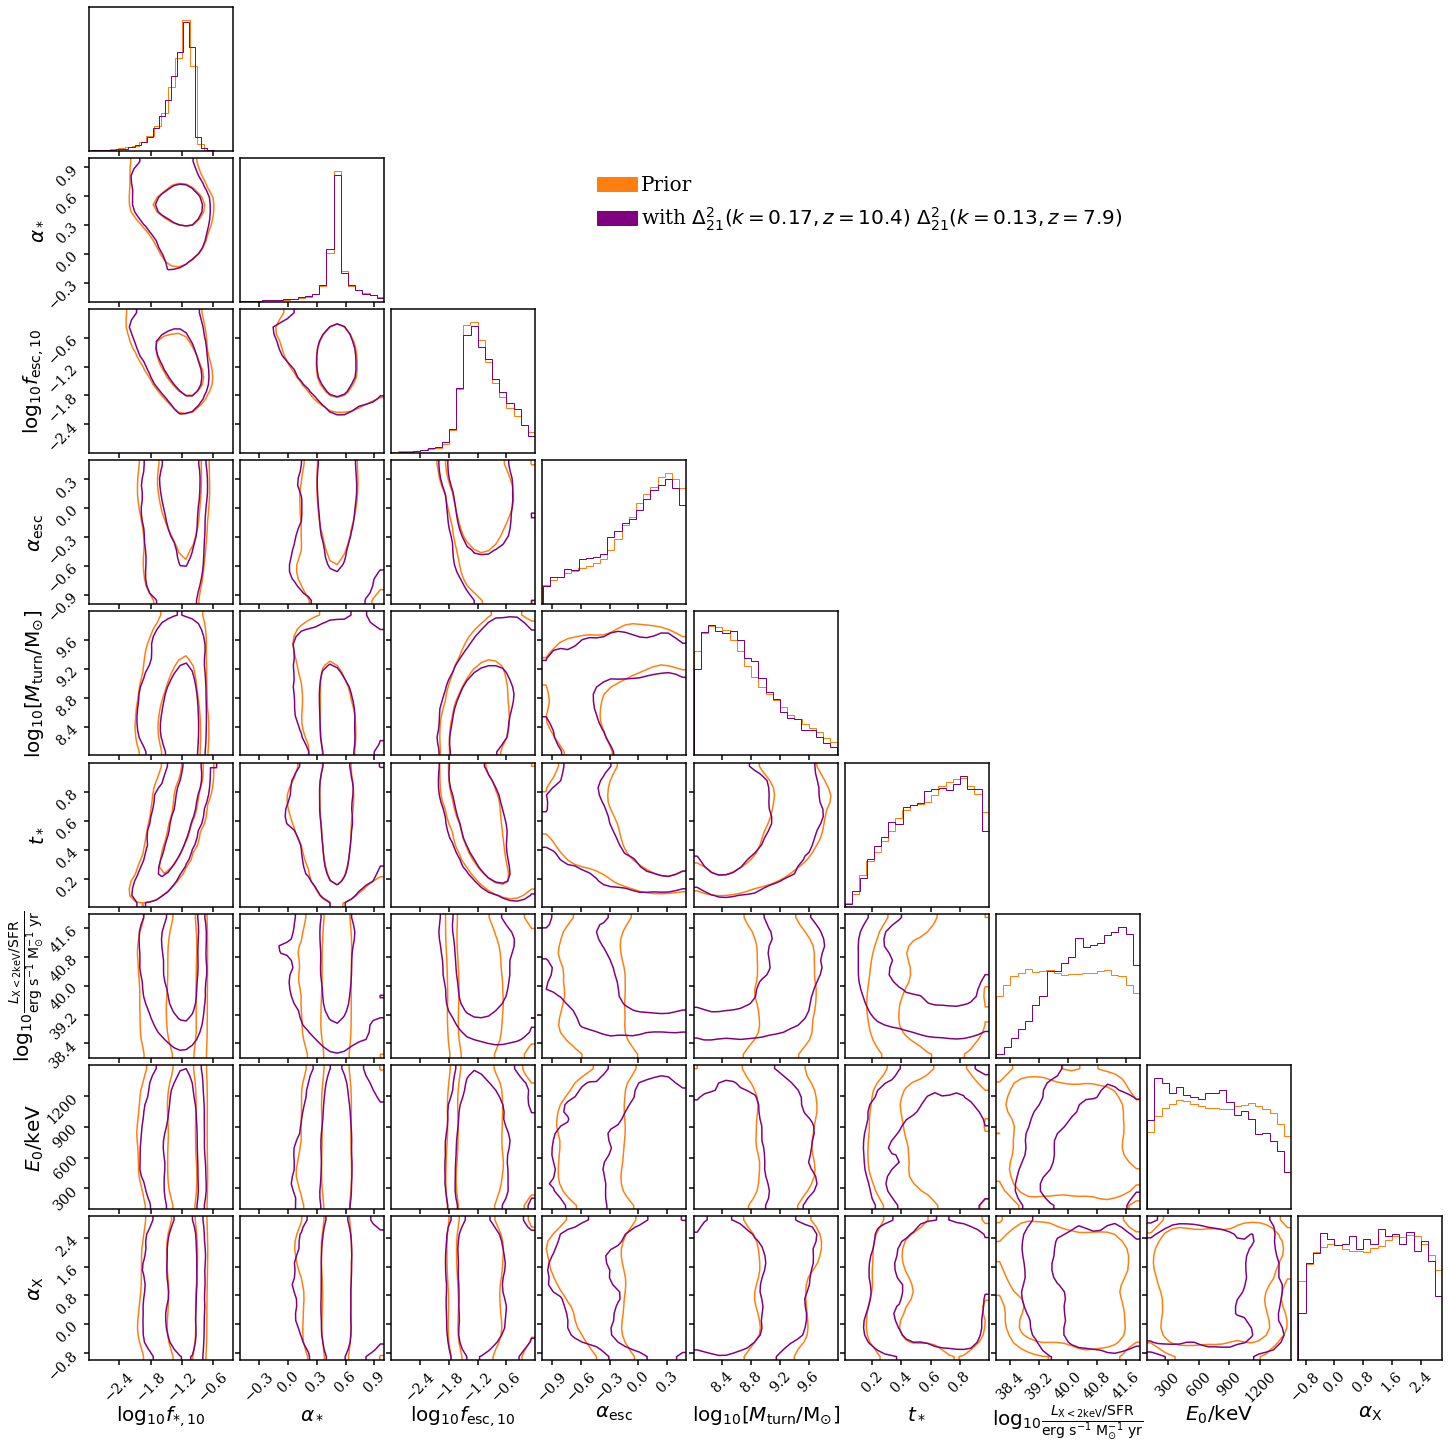

In [10]:
fig = DFM.corner(thetas, 
                 levels=[0.68, 0.95], 
                 color='C1',
                 labels=lbl_params,
                 label_kwargs={'fontsize': 20},
                 hist_kwargs={'density': True},
                 smooth=True, plot_datapoints=False, plot_density=False, fill_contours=False)
_ = DFM.corner(np.array(mcmc_npe.detach().to('cpu')), color='purple', 
               levels=[0.68, 0.95], 
               labels=lbl_params,
               label_kwargs={'fontsize': 20},
               hist_kwargs={'density': True},
               smooth=True, plot_datapoints=False, plot_density=False, fig=fig)

ndim = 9
axes = np.array(fig.axes).reshape((ndim, ndim))

ax = axes[1, ndim-3]
ax.fill_between([], [], [], color='C1', label='Prior')
ax.fill_between([], [], [], color='purple', label=r'with $\Delta_{21}^2(k=0.17, z=10.4)$ $\Delta_{21}^2(k=0.13, z=7.9)$')
ax.legend(handletextpad=0.2, markerscale=10, fontsize=20)

# lower noise levels

3x smaller error bars
9x smaller error bars
27x smaller error bars
81x smaller error bars


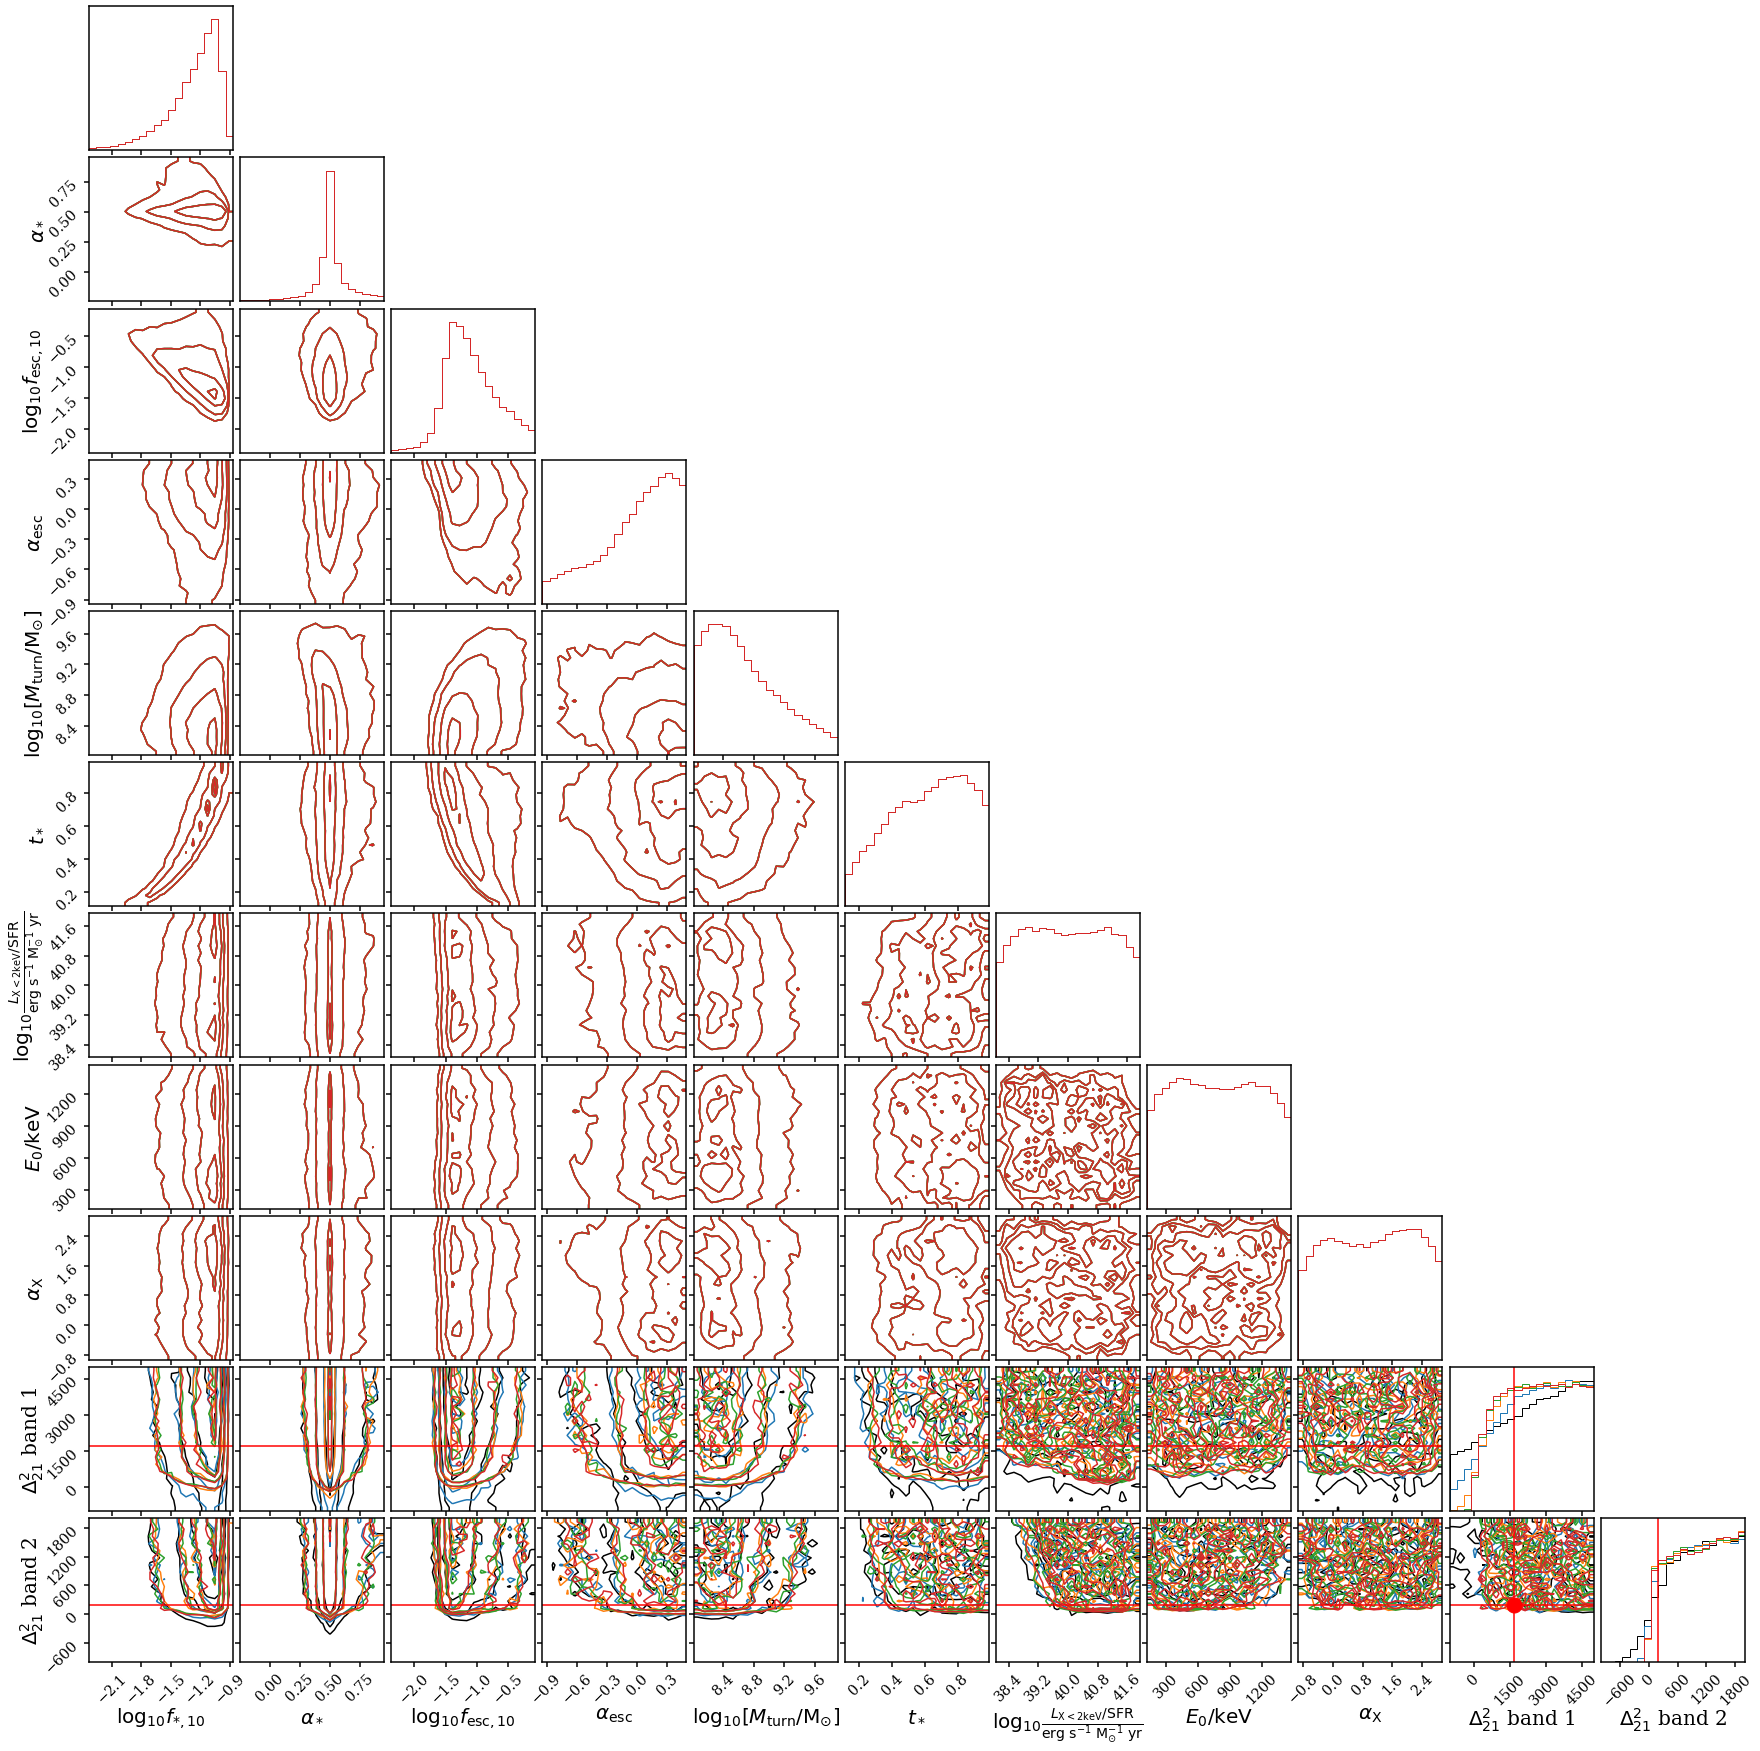

In [11]:
fig = DFM.corner(np.concatenate([thetas, obs], axis=1), 
                 range=[np.quantile(tt, (0.01, 0.99)) for tt in thetas.T] + [(-1000., 5000), (-1000., 2000)], 
                 color='k', hist_kwargs={"density": True}, 
                 labels=list(lbl_params) + [r'$\Delta_{21}^2$ band 1', r'$\Delta_{21}^2$ band 2'],
                 label_kwargs={'fontsize': 20}, plot_density=False, plot_datapoints=False)

for i, sigma_scale in enumerate([3, 9, 27, 81]):
    print('%ix smaller error bars' % sigma_scale)
    dat_dir = '/scratch/gpfs/chhahn/21cmlfi/'
    f = h5py.File(os.path.join(dat_dir, '21cmlfi.hdf5'), 'r')
    _obs = f['Del2_21_noise_%ix' % sigma_scale][...]
    f.close()
        
    _ = DFM.corner(np.concatenate([thetas, _obs], axis=1),
                   range=[np.quantile(tt, (0.01, 0.99)) for tt in thetas.T] + [(-1000., 5000), (-1000., 2000)], 
                   color='C%i' % i, hist_kwargs={"density": True}, 
                   labels=list(lbl_params) + [r'$\Delta_{21}^2$ band 1', r'$\Delta_{21}^2$ band 2'],
                   label_kwargs={'fontsize': 20}, plot_density=False, plot_datapoints=False, fig=fig)
    
DFM.overplot_points(fig, [[None for _ in lbl_params] + delta_obs], color='r', markersize=30)
DFM.overplot_lines(fig, [None for _ in lbl_params] + delta_obs, color='r')
plt.show()

In [12]:
delta_obs

array([1700.,  200.])

3x smaller error bars
9x smaller error bars
27x smaller error bars


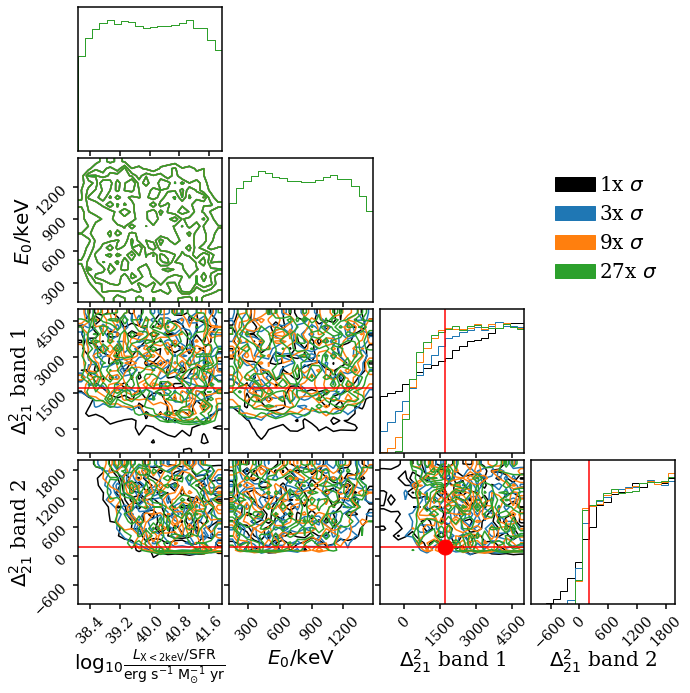

In [12]:
fig = DFM.corner(np.concatenate([thetas[:,6:8], obs], axis=1), 
                 range=[np.quantile(tt, (0.01, 0.99)) for tt in thetas.T[6:8]] + [(-1000., 5000), (-1000., 2000)], 
                 color='k', hist_kwargs={"density": True}, 
                 labels=list(lbl_params[6:8]) + [r'$\Delta_{21}^2$ band 1', r'$\Delta_{21}^2$ band 2'],
                 label_kwargs={'fontsize': 20}, plot_density=False, plot_datapoints=False)

for i, sigma_scale in enumerate([3, 9, 27]):
    print('%ix smaller error bars' % sigma_scale)
    dat_dir = '/scratch/gpfs/chhahn/21cmlfi/'
    f = h5py.File(os.path.join(dat_dir, '21cmlfi.hdf5'), 'r')
    _obs = f['Del2_21_noise_%ix' % sigma_scale][...]
    f.close()
    
    _ = DFM.corner(np.concatenate([thetas[:,6:8], _obs], axis=1),
                   range=[np.quantile(tt, (0.01, 0.99)) for tt in thetas.T[6:8]] + [(-1000., 5000), (-1000., 2000)], 
                   color='C%i' % i, hist_kwargs={"density": True}, 
                   labels=list(lbl_params[6:8]) + [r'$\Delta_{21}^2$ band 1', r'$\Delta_{21}^2$ band 2'],
                   label_kwargs={'fontsize': 20}, plot_density=False, plot_datapoints=False, fig=fig)
    
DFM.overplot_points(fig, [[None for _ in range(2)] + delta_obs], color='r', markersize=30)
DFM.overplot_lines(fig, [None for _ in range(2)] + delta_obs, color='r')

ndim = 4
axes = np.array(fig.axes).reshape((ndim, ndim))

ax = axes[1, ndim-1]
ax.fill_between([], [], [], color='k', label=r'1x $\sigma$')
for i, sigma_scale in zip(range(3), [3, 9, 27]): 
    ax.fill_between([], [], [], color='C%i' % i, label=r'%ix $\sigma$' % sigma_scale)
ax.legend(handletextpad=0.2, markerscale=10, fontsize=20)

plt.show()

In [13]:
mcmcs = []
for sigma_scale in [3, 9, 27, 81]:
    dir_npe = '/scratch/gpfs/chhahn/21cmlfi/npes/'
    best_phat = torch.load(os.path.join(dir_npe, 'npe.erf_%ix.pt' % sigma_scale), map_location=torch.device('cpu'))
    
    # sample posterior p(theta | x)
    _mcmc = best_phat.sample((10000,), 
                             x=torch.as_tensor(np.array(delta_obs).astype(np.float32)).to('cpu'), 
                             show_progress_bars=True)
    mcmcs.append(np.array(_mcmc.detach().to('cpu')))

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

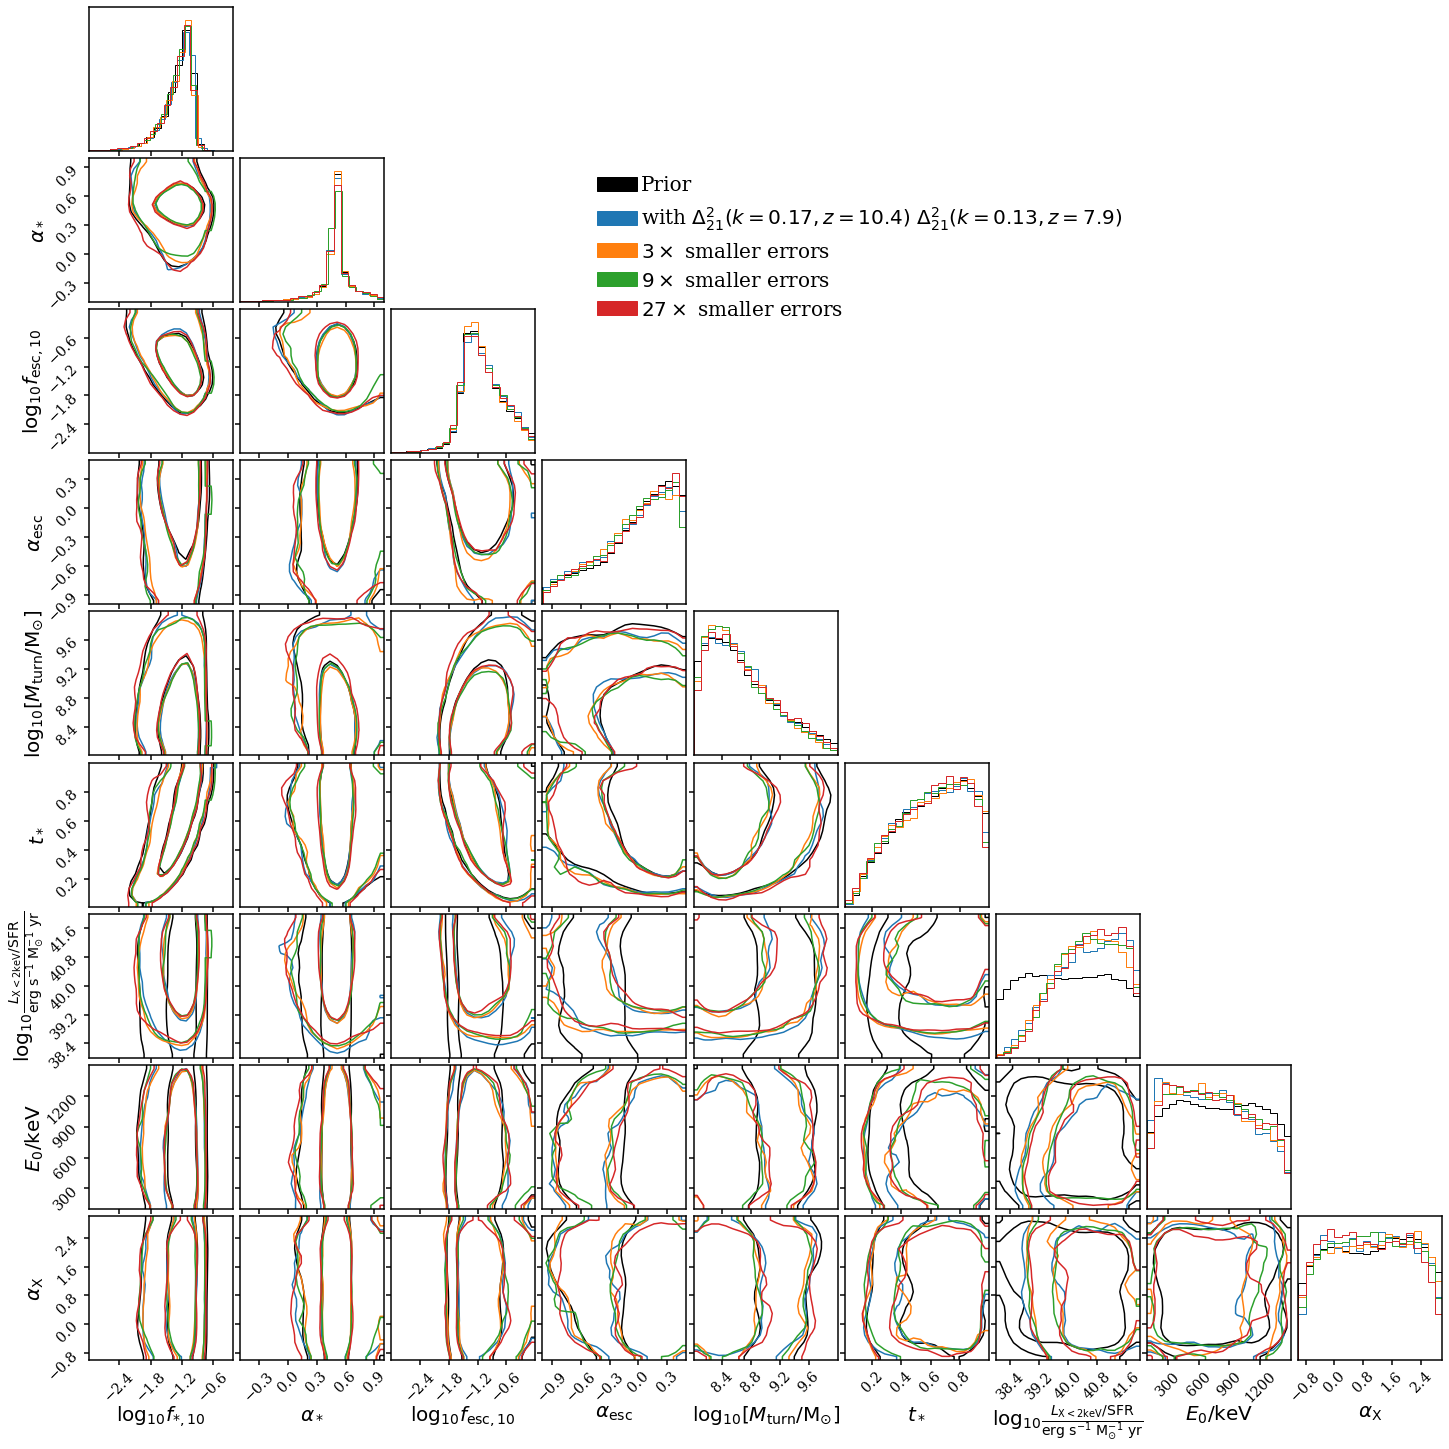

In [14]:
fig = DFM.corner(thetas, 
                 levels=[0.68, 0.95], 
                 color='k',
                 labels=lbl_params,
                 label_kwargs={'fontsize': 20},
                 hist_kwargs={'density': True},
                 smooth=True, plot_datapoints=False, plot_density=False, fill_contours=False)
_ = DFM.corner(np.array(mcmc_npe.detach().to('cpu')), color='C0', 
               levels=[0.68, 0.95], 
               labels=lbl_params,
               label_kwargs={'fontsize': 20},
               hist_kwargs={'density': True},
               smooth=True, plot_datapoints=False, plot_density=False, fig=fig)

for i, sigma_scale, _mcmc in zip(range(3), [3, 9, 27], mcmcs): 
    _ = DFM.corner(_mcmc, color='C%i' % (i+1), 
               levels=[0.68, 0.95], 
               labels=lbl_params,
               label_kwargs={'fontsize': 20},
               hist_kwargs={'density': True},
               smooth=True, plot_datapoints=False, plot_density=False, fig=fig)


ndim = 9
axes = np.array(fig.axes).reshape((ndim, ndim))

ax = axes[1, ndim-3]
ax.fill_between([], [], [], color='k', label='Prior')
ax.fill_between([], [], [], color='C0', label=r'with $\Delta_{21}^2(k=0.17, z=10.4)$ $\Delta_{21}^2(k=0.13, z=7.9)$')
for i, sigma_scale in zip(range(3), [3, 9, 27]): 
    ax.fill_between([], [], [], color='C%i' % (i+1), label=r'$%i\times$ smaller errors' % sigma_scale)
ax.legend(handletextpad=0.2, markerscale=10, fontsize=20)

# derive NPE posterior for measurement 
$${\bf x} = [0, 0]$$

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

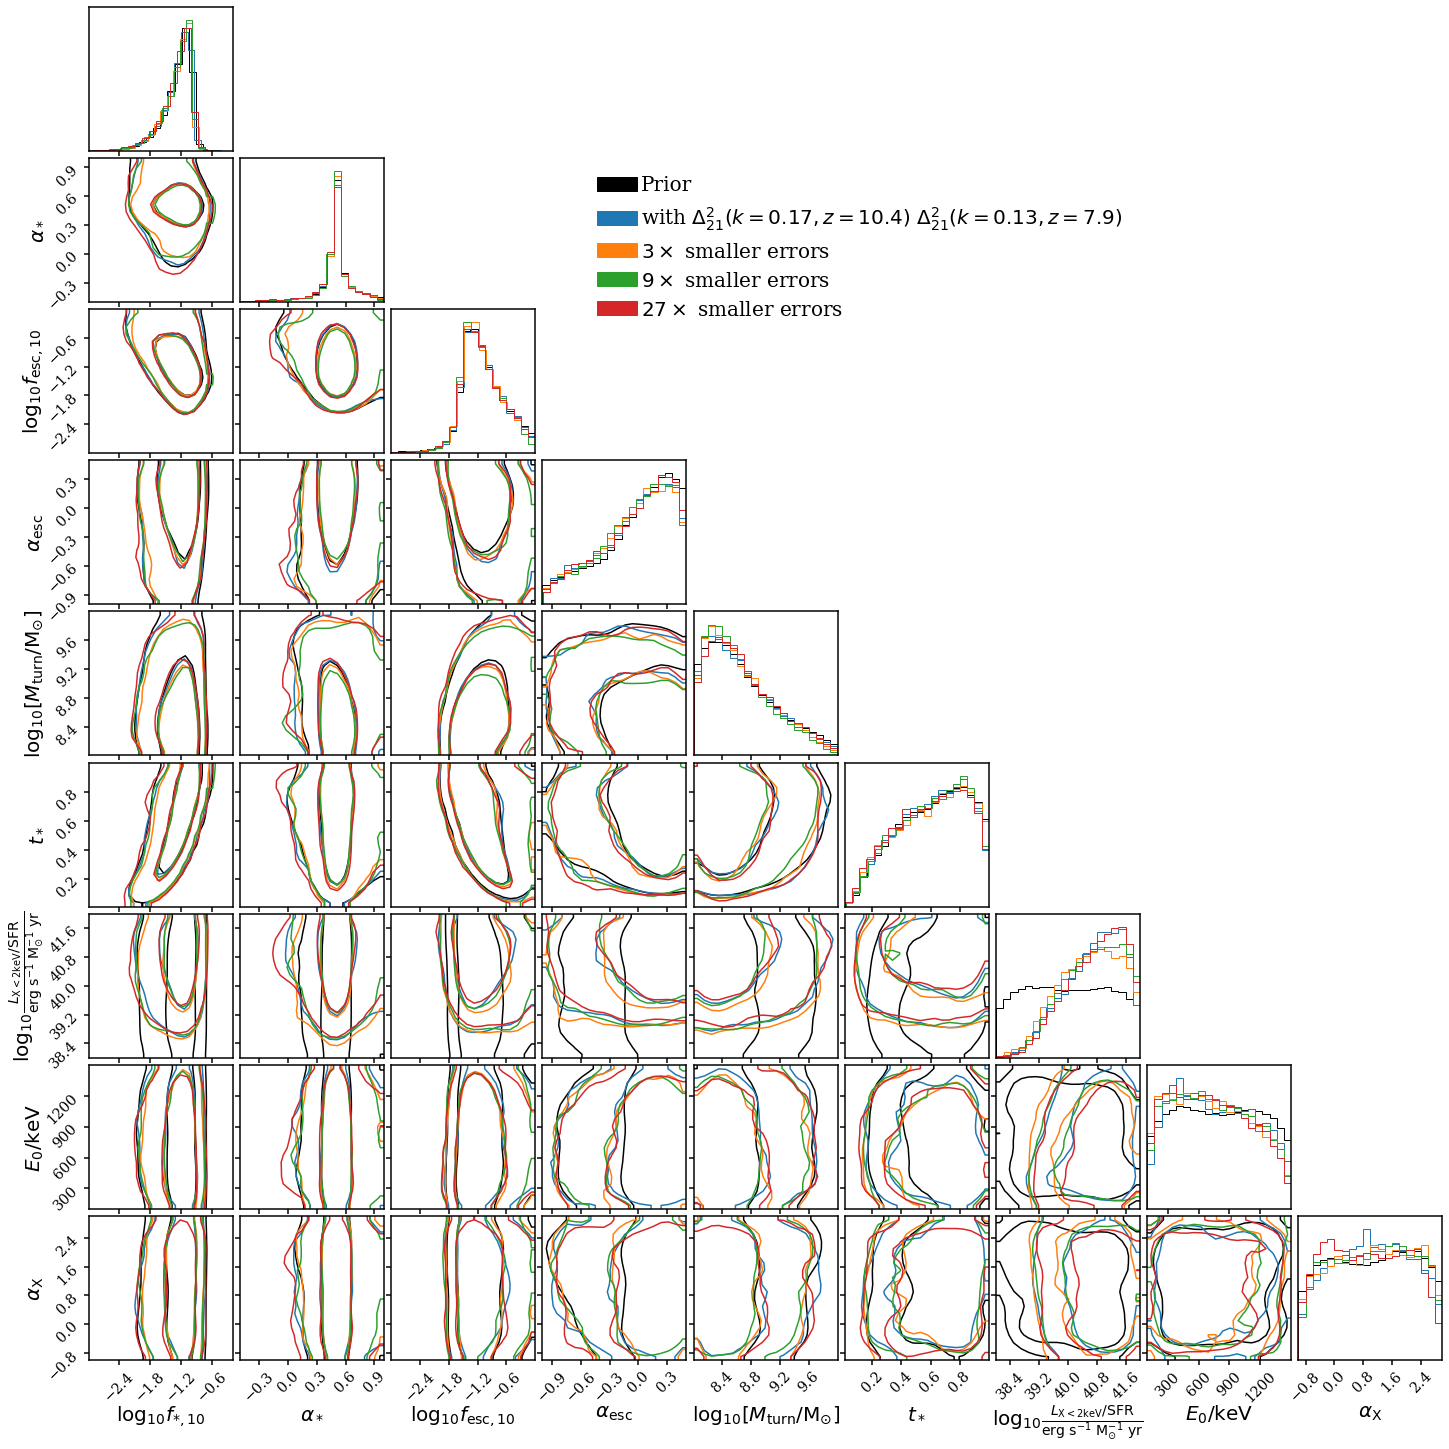

In [15]:
delta_obs = [0., 0.]

mcmc_npe = best_phat.sample((10000,), 
                            x=torch.as_tensor(np.array(delta_obs).astype(np.float32)).to('cpu'), 
                            show_progress_bars=True)

mcmcs = []
for sigma_scale in [3, 9, 27, 81]:
    dir_npe = '/scratch/gpfs/chhahn/21cmlfi/npes/'
    best_phat = torch.load(os.path.join(dir_npe, 'npe.erf_%ix.pt' % sigma_scale), map_location=torch.device('cpu'))
    
    # sample posterior p(theta | x)
    _mcmc = best_phat.sample((10000,), 
                             x=torch.as_tensor(np.array(delta_obs).astype(np.float32)).to('cpu'), 
                             show_progress_bars=True)
    mcmcs.append(np.array(_mcmc.detach().to('cpu')))
    
fig = DFM.corner(thetas, 
                 levels=[0.68, 0.95], 
                 color='k',
                 labels=lbl_params,
                 label_kwargs={'fontsize': 20},
                 hist_kwargs={'density': True},
                 smooth=True, plot_datapoints=False, plot_density=False, fill_contours=False)
_ = DFM.corner(np.array(mcmc_npe.detach().to('cpu')), color='C0', 
               levels=[0.68, 0.95], 
               labels=lbl_params,
               label_kwargs={'fontsize': 20},
               hist_kwargs={'density': True},
               smooth=True, plot_datapoints=False, plot_density=False, fig=fig)

for i, sigma_scale, _mcmc in zip(range(3), [3, 9, 27], mcmcs): 
    _ = DFM.corner(_mcmc, color='C%i' % (i+1), 
               levels=[0.68, 0.95], 
               labels=lbl_params,
               label_kwargs={'fontsize': 20},
               hist_kwargs={'density': True},
               smooth=True, plot_datapoints=False, plot_density=False, fig=fig)


ndim = 9
axes = np.array(fig.axes).reshape((ndim, ndim))

ax = axes[1, ndim-3]
ax.fill_between([], [], [], color='k', label='Prior')
ax.fill_between([], [], [], color='C0', label=r'with $\Delta_{21}^2(k=0.17, z=10.4)$ $\Delta_{21}^2(k=0.13, z=7.9)$')
for i, sigma_scale in zip(range(3), [3, 9, 27]): 
    ax.fill_between([], [], [], color='C%i' % (i+1), label=r'$%i\times$ smaller errors' % sigma_scale)
ax.legend(handletextpad=0.2, markerscale=10, fontsize=20)    

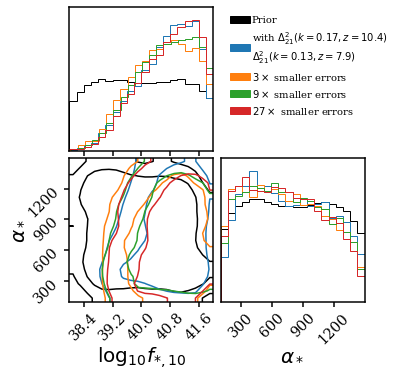

In [32]:
fig = DFM.corner(thetas[:,6:8], 
                 levels=[0.68, 0.95], 
                 color='k',
                 labels=lbl_params,
                 label_kwargs={'fontsize': 20},
                 hist_kwargs={'density': True},
                 smooth=True, plot_datapoints=False, plot_density=False, fill_contours=False)
_ = DFM.corner(np.array(mcmc_npe.detach().to('cpu'))[:,6:8], color='C0', 
               levels=[0.68, 0.95], 
               labels=lbl_params,
               label_kwargs={'fontsize': 20},
               hist_kwargs={'density': True},
               smooth=True, plot_datapoints=False, plot_density=False, fig=fig)

for i, sigma_scale, _mcmc in zip(range(3), [3, 9, 27], mcmcs): 
    _ = DFM.corner(_mcmc[:,6:8], color='C%i' % (i+1), 
               levels=[0.68, 0.95], 
               labels=lbl_params,
               label_kwargs={'fontsize': 20},
               hist_kwargs={'density': True},
               smooth=True, plot_datapoints=False, plot_density=False, fig=fig)


ndim = 2
axes = np.array(fig.axes).reshape((ndim, ndim))

ax = axes[0,1]#ndim-3]
ax.fill_between([], [], [], color='k', label='Prior')
ax.fill_between([], [], [], color='C0', label=r'with $\Delta_{21}^2(k=0.17, z=10.4)$'+'\n'+r'$\Delta_{21}^2(k=0.13, z=7.9)$')
for i, sigma_scale in zip(range(3), [3, 9, 27]): 
    ax.fill_between([], [], [], color='C%i' % (i+1), label=r'$%i\times$ smaller errors' % sigma_scale)
ax.legend(loc='upper left', handletextpad=0.2, markerscale=10, fontsize=10)    